# Consumer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.preprocessing import OneHotEncoder
import pickle
import xgboost as xgb
import requests
from sklearn.preprocessing import StandardScaler

In [2]:
df2days = pd.read_csv('/home/abdulazizf/code/afnanzayed/Renewable_Energy/raw_data/sep_month_A.csv')
df1month = pd.read_csv('/home/abdulazizf/code/afnanzayed/Renewable_Energy/raw_data/sep_month_B.csv')

df = pd.concat([df2days, df1month], ignore_index=True)

In [3]:
df['Date'] = pd.to_datetime(df['time'])

df.set_index('Date', inplace=True)

df.index = pd.to_datetime(df.index)
df['Date'] = df.index.date

KSA_holidays = holidays.SA(years=[2024])
df['IsHoliday'] = df['Date'].apply(lambda x: 1 if x in KSA_holidays else 0)

df= df.drop(columns='time')

In [4]:
df.rename(columns={
    'temperature_2m (°C)': 'Temperature',
    'relative_humidity_2m (%)': 'Humidity',
    'wind_speed_10m (km/h)': 'WindSpeed',
}, inplace=True)
df = df[['Temperature', 'Humidity', 'WindSpeed','IsHoliday' ]]
df['WindSpeed']= df['WindSpeed']/ 3.6
df

,Temperature,Humidity,WindSpeed,IsHoliday
Date,,,,
2024-08-30 00:00:00,31.7,40,8.194444,0
2024-08-30 01:00:00,31.5,39,8.166667,0
2024-08-30 02:00:00,31.1,38,8.166667,0
2024-08-30 03:00:00,30.6,36,8.388889,0
2024-08-30 04:00:00,30.6,36,8.666667,0
...,...,...,...,...
2024-09-30 19:00:00,30.1,34,7.555556,0
2024-09-30 20:00:00,29.2,38,7.111111,0
2024-09-30 21:00:00,28.5,42,7.777778,0


In [5]:
KSA_holidays = holidays.SA(years=[2024])

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Hour'] = df.index.hour

def categorize_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(categorize_season)

def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'
df['TimeOfDay'] = df['Hour'].apply(categorize_time_of_day)
df['Weekday'] = df.index.weekday  # Access weekday from index
# Add a column to indicate if it's a weekend
df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 4 else 0)

df = df.drop(columns = ['Weekday'])

In [6]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[['Season']])
df[ohe.get_feature_names_out(['Season'])] = ohe.transform(df[['Season']])

df['Season_Autumn']=0
df['Season_Spring']=0
df['Season_Summer']=0
df['Season_Winter']=0
ohe.fit(df[['TimeOfDay']])
df[ohe.get_feature_names_out(['TimeOfDay'])] = ohe.transform(df[['TimeOfDay']])

df = df.drop(columns = ['Season', 'TimeOfDay'])

df.head()

,Temperature,Humidity,WindSpeed,IsHoliday,Year,Month,Day,Hour,IsWeekend,Season_Autumn,Season_Summer,Season_Spring,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night
Date,,,,,,,,,,,,,,,,,
2024-08-30 00:00:00,31.7,40,8.194444,0,2024,8,30,0,1,0,0,0,0,0.0,0.0,0.0,1.0
2024-08-30 01:00:00,31.5,39,8.166667,0,2024,8,30,1,1,0,0,0,0,0.0,0.0,0.0,1.0
2024-08-30 02:00:00,31.1,38,8.166667,0,2024,8,30,2,1,0,0,0,0,0.0,0.0,0.0,1.0
2024-08-30 03:00:00,30.6,36,8.388889,0,2024,8,30,3,1,0,0,0,0,0.0,0.0,0.0,1.0
2024-08-30 04:00:00,30.6,36,8.666667,0,2024,8,30,4,1,0,0,0,0,0.0,0.0,0.0,1.0


In [7]:
lags = [x for x in range(2,49,2)]
columns_to_lag = [
    'Temperature', 'Humidity', 'WindSpeed'
]

for col in columns_to_lag:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

df_lagged = df.dropna()

In [8]:
columns = ['Temperature', 'Humidity', 'WindSpeed', 'Year', 'Month', 'Day', 'Hour',
       'IsHoliday', 'IsWeekend', 'Season_Autumn', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'TimeOfDay_Afternoon',
       'TimeOfDay_Evening', 'TimeOfDay_Morning', 'TimeOfDay_Night',
       'Temperature_lag2', 'Temperature_lag4', 'Temperature_lag6',
       'Temperature_lag8', 'Temperature_lag10', 'Temperature_lag12',
       'Temperature_lag14', 'Temperature_lag16', 'Temperature_lag18',
       'Temperature_lag20', 'Temperature_lag22', 'Temperature_lag24',
       'Temperature_lag26', 'Temperature_lag28', 'Temperature_lag30',
       'Temperature_lag32', 'Temperature_lag34', 'Temperature_lag36',
       'Temperature_lag38', 'Temperature_lag40', 'Temperature_lag42',
       'Temperature_lag44', 'Temperature_lag46', 'Temperature_lag48',
       'Humidity_lag2', 'Humidity_lag4', 'Humidity_lag6', 'Humidity_lag8',
       'Humidity_lag10', 'Humidity_lag12', 'Humidity_lag14', 'Humidity_lag16',
       'Humidity_lag18', 'Humidity_lag20', 'Humidity_lag22', 'Humidity_lag24',
       'Humidity_lag26', 'Humidity_lag28', 'Humidity_lag30', 'Humidity_lag32',
       'Humidity_lag34', 'Humidity_lag36', 'Humidity_lag38', 'Humidity_lag40',
       'Humidity_lag42', 'Humidity_lag44', 'Humidity_lag46', 'Humidity_lag48',
       'WindSpeed_lag2', 'WindSpeed_lag4', 'WindSpeed_lag6', 'WindSpeed_lag8',
       'WindSpeed_lag10', 'WindSpeed_lag12', 'WindSpeed_lag14',
       'WindSpeed_lag16', 'WindSpeed_lag18', 'WindSpeed_lag20',
       'WindSpeed_lag22', 'WindSpeed_lag24', 'WindSpeed_lag26',
       'WindSpeed_lag28', 'WindSpeed_lag30', 'WindSpeed_lag32',
       'WindSpeed_lag34', 'WindSpeed_lag36', 'WindSpeed_lag38',
       'WindSpeed_lag40', 'WindSpeed_lag42', 'WindSpeed_lag44',
       'WindSpeed_lag46', 'WindSpeed_lag48']

df_lagged = df_lagged[columns]

In [9]:
from sklearn.preprocessing import MinMaxScaler
columns_to_scale = df_lagged.select_dtypes(include=['float64', 'int64', 'int32']).columns


scaler = MinMaxScaler()
df_lagged[columns_to_scale] = scaler.fit_transform(df_lagged[columns_to_scale])
pd.set_option('display.max_columns', None)
df_lagged.head()


,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,Temperature_lag2,Temperature_lag4,Temperature_lag6,Temperature_lag8,Temperature_lag10,Temperature_lag12,Temperature_lag14,Temperature_lag16,Temperature_lag18,Temperature_lag20,Temperature_lag22,Temperature_lag24,Temperature_lag26,Temperature_lag28,Temperature_lag30,Temperature_lag32,Temperature_lag34,Temperature_lag36,Temperature_lag38,Temperature_lag40,Temperature_lag42,Temperature_lag44,Temperature_lag46,Temperature_lag48,Humidity_lag2,Humidity_lag4,Humidity_lag6,Humidity_lag8,Humidity_lag10,Humidity_lag12,Humidity_lag14,Humidity_lag16,Humidity_lag18,Humidity_lag20,Humidity_lag22,Humidity_lag24,Humidity_lag26,Humidity_lag28,Humidity_lag30,Humidity_lag32,Humidity_lag34,Humidity_lag36,Humidity_lag38,Humidity_lag40,Humidity_lag42,Humidity_lag44,Humidity_lag46,Humidity_lag48,WindSpeed_lag2,WindSpeed_lag4,WindSpeed_lag6,WindSpeed_lag8,WindSpeed_lag10,WindSpeed_lag12,WindSpeed_lag14,WindSpeed_lag16,WindSpeed_lag18,WindSpeed_lag20,WindSpeed_lag22,WindSpeed_lag24,WindSpeed_lag26,WindSpeed_lag28,WindSpeed_lag30,WindSpeed_lag32,WindSpeed_lag34,WindSpeed_lag36,WindSpeed_lag38,WindSpeed_lag40,WindSpeed_lag42,WindSpeed_lag44,WindSpeed_lag46,WindSpeed_lag48
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-01 00:00:00,0.271739,0.313433,0.743073,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.315217,0.407609,0.516304,0.614130,0.771739,0.809783,0.711957,0.521739,0.326087,0.164835,0.183333,0.250000,0.327778,0.488889,0.622222,0.711111,0.872222,0.927778,0.855556,0.661111,0.427778,0.266667,0.294444,0.327778,0.432836,0.343284,0.238806,0.164179,0.074627,0.044776,0.089552,0.238806,0.402985,0.477612,0.417910,0.328358,0.447761,0.208955,0.119403,0.089552,0.014925,0.000000,0.029412,0.161765,0.308824,0.411765,0.441176,0.470588,0.745592,0.788413,0.780856,0.712846,0.801008,0.831234,0.753149,0.846348,0.838791,0.773300,0.773300,0.745592,0.806045,0.780856,0.642317,0.612091,0.526448,0.773300,0.710327,0.720403,0.753149,0.758186,0.712846,0.715365
2024-09-01 01:00:00,0.293478,0.328358,0.770781,0.0,0.0,0.0,0.043478,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.298913,0.353261,0.451087,0.565217,0.711957,0.788043,0.777174,0.625000,0.407609,0.225275,0.150000,0.222222,0.272222,0.411111,0.550000,0.661111,0.816667,0.883333,0.911111,0.772222,0.538889,0.327778,0.266667,0.316667,0.343284,0.417910,0.298507,0.194030,0.104478,0.059701,0.059701,0.164179,0.358209,0.462687,0.477612,0.373134,0.477612,0.328358,0.179104,0.104478,0.044776,0.044118,0.000000,0.088235,0.235294,0.382353,0.411765,0.455882,0.745592,0.725441,0.811083,0.745592,0.770781,0.793451,0.778338,0.778338,0.871537,0.750630,0.778338,0.768262,0.745592,0.803526,0.725441,0.526448,0.541562,0.551637,0.697733,0.695214,0.738035,0.715365,0.732997,0.712846
2024-09-01 02:00:00,0.255435,0.373134,0.780856,0.0,0.0,0.0,0.086957,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.271739,0.315217,0.407609,0.516304,0.614130,0.771739,0.809783,0.711957,0.521739,0.318681,0.155556,0.183333,0.250000,0.327778,0.488889,0.622222,0.711111,0.872222,0.927778,0.855556,0.661111,0.427778,0.266667,0.294444,0.313433,0.432836,0.343284,0.238806,0.164179,0.074627,0.044776,0.089552,0.238806,0.402985,0.477612,0.417910,0.328358,0.447761,0.208955,0.119403,0.089552,0.029412,0.000000,0.029412,0.161765,0.308824,0.411765,0.441176,0.743073,0.745592,0.788413,0.780856,0.712846,0.801008,0.831234,0.753149,0.846348,0.838791,0.773300,0.773300,0.745592,0.806045,0.780856,0.642317,0.612091,0.526448,0.773300,0.710327,0.720403,0.753149,0.758186,0.712846
2024-09-01 03:00:00,0.222826,0.447761,0.770781,0.0,0.0,0.0,0.130435,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.293478,0.298913,0.353261,0.451087,0.565217,0.711957,0.788043,0.777174,0.625000,0.401099,0.216667,0.150000,0.222222,0.272222,0.411111,0.550000,0.661111,0.816667,0.88

In [10]:
my_model = pickle.load(open("xgb_cons_abdlaziz.pkl","rb"))

In [11]:
dlagged = xgb.DMatrix(df_lagged)
prediction = my_model.predict(dlagged) * 4
prediction

array([1.2183653 , 0.9863866 , 0.8854382 , 0.72920513, 0.63801235,
       0.55582845, 0.5949015 , 0.5949015 , 0.88769066, 1.2339762 ,
       1.510796  , 1.6726836 , 1.7140095 , 1.7415847 , 1.7690699 ,
       1.7688413 , 1.6803874 , 1.7062844 , 2.1204503 , 2.648119  ,
       2.6500716 , 2.6120975 , 2.4090576 , 2.111505  , 1.2442924 ,
       0.9682583 , 0.8478606 , 0.7133068 , 0.6548357 , 0.5809153 ,
       0.5687566 , 0.5849858 , 0.93230015, 1.2743618 , 1.6528147 ,
       1.8181185 , 1.8176482 , 1.8749586 , 1.7490035 , 1.7334012 ,
       1.6322634 , 1.6843302 , 2.2108579 , 2.6953454 , 2.734157  ,
       2.7115757 , 2.4563828 , 2.1553988 , 1.2734005 , 1.0642408 ,
       0.8610553 , 0.75295943, 0.6548357 , 0.5809153 , 0.5687566 ,
       0.7006765 , 0.9532674 , 1.396238  , 1.6713942 , 1.8181185 ,
       1.8452233 , 1.8749586 , 1.8496876 , 1.7359774 , 1.749415  ,
       1.7487247 , 2.2283401 , 2.6920128 , 2.7517674 , 2.6559913 ,
       2.4563828 , 2.1553988 , 1.2734005 , 1.0488778 , 0.86105

In [12]:
# Convert predictions into a DataFrame
predictions_df = pd.DataFrame(prediction, index=df_lagged.index, columns=['Prediction'])

# Display the new DataFrame with the same index as df_lagged
predictions_df.head()

,Prediction
Date,
2024-09-01 00:00:00,1.218365
2024-09-01 01:00:00,0.986387
2024-09-01 02:00:00,0.885438
2024-09-01 03:00:00,0.729205
2024-09-01 04:00:00,0.638012


In [13]:
daily_sum = (predictions_df.resample('D').sum() * 300000).round()

daily_sum

,Prediction
Date,
2024-09-01,10931899.0
2024-09-02,11188839.0
2024-09-03,11411921.0
2024-09-04,11354900.0
2024-09-05,11129502.0
2024-09-06,10295705.0
2024-09-07,10117168.0
2024-09-08,9971751.0
2024-09-09,10290868.0


# Producer

In [14]:
data= pd.read_csv('/home/abdulazizf/code/afnanzayed/Renewable_Energy/Ds_bootcamp_models/Dataset/open-meteo.csv')

API_KEY = "tvATzwa1FudZ9qOK2oWYRDpkNdPsiall"
lat= 28.2344
lon = 34.8444
url =f'https://api.solcast.com.au/data/historic/radiation_and_weather?latitude={lat}&longitude={lon}&azimuth=44&tilt=90&start=2024-09-01T00:00:00.000Z&end=2024-10-01T00:00:00.000Z&format=json&time_zone=utc&period=PT60M'
headers = {"Authorization": f"Bearer {API_KEY}"}
response = requests.get(url,headers=headers)

def convert_ghi_to_dataframe(api_response):
    # Initialize an empty list to store the extracted data
    ghi_data = []

    # Loop through each entry in 'estimated_actuals'
    for entry in api_response.get('estimated_actuals', []):
        # Extract the 'ghi' and 'period_end' values
        ghi = entry.get('ghi', None)
        period_end = entry.get('period_end', None)

        # Append these values as a tuple to the list
        ghi_data.append({'Period_End': period_end, 'GHI': ghi})

    # Convert the list to a DataFrame
    df = pd.DataFrame(ghi_data)

    return df

In [15]:
ghi_df = convert_ghi_to_dataframe(response.json())
data[["time","temperature_2m (°C)",	"soil_temperature_0_to_7cm (°C)"]]
neom_df = pd.concat([ghi_df[["GHI"]],data[["time","temperature_2m (°C)", "soil_temperature_0_to_7cm (°C)"]]], axis=1)
neom_df = neom_df.rename(columns={'temperature_2m (°C)': 'AMBIENT_TEMPERATURE', 'soil_temperature_0_to_7cm (°C)': 'MODULE_TEMPERATURE', 'GHI': 'IRRADIATION'})
neom_df = neom_df[['time', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']]
neom_df['Date'] = pd.to_datetime(neom_df['time'])

neom_df.set_index('Date', inplace=True)
neom_df.index = pd.to_datetime(neom_df.index)
neom_df['Date'] = neom_df.index.date
neom_df= neom_df.drop(columns='time')

In [16]:
prod_model = pickle.load(open("xgb_prod_abdlaziz.pkl","rb"))

In [17]:
preproc = StandardScaler()


In [18]:
X_new = neom_df[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']]

X_new_preproc = preproc.fit_transform(X_new)
y_pred_log = prod_model.predict(X_new_preproc)
y_pred = np.expm1(y_pred_log)
dc_pred = pd.Series(y_pred).map(lambda x:x if x>=0 else 0)


In [19]:
y_pred

array([-9.9999899e-01, -9.9999899e-01, -9.9999899e-01,  8.2000113e+00,
        1.1029071e+02,  4.8700528e+02,  5.4690021e+02,  6.1152234e+02,
        6.3226538e+02,  6.4043719e+02,  6.7717242e+02,  7.2838605e+02,
        7.2037671e+02,  5.6110809e+02,  3.1056061e+02,  6.2516212e+01,
       -9.9999899e-01, -9.9999899e-01, -9.9999899e-01, -9.9999899e-01,
       -9.9999899e-01, -9.9999899e-01, -9.9999899e-01, -9.9999899e-01,
       -9.9999899e-01, -9.9999899e-01, -9.9999899e-01,  8.1585388e+00,
        2.1697925e+02,  4.8153952e+02,  5.4690021e+02,  6.1152234e+02,
        6.3226538e+02,  6.4043719e+02,  6.7717242e+02,  7.2838605e+02,
        7.2037671e+02,  5.6110809e+02,  3.1056061e+02,  6.2678818e+01,
       -9.9999899e-01, -9.9999899e-01, -9.9999899e-01, -9.9999899e-01,
       -9.9999899e-01, -9.9999899e-01, -9.9999899e-01, -9.9999899e-01,
       -9.9999899e-01, -9.9999899e-01, -9.9999899e-01,  8.1585388e+00,
        2.1697925e+02,  4.8153952e+02,  5.4690021e+02,  6.1152234e+02,
      

In [20]:
dc_predec = pd.DataFrame(dc_pred, index=neom_df.index, columns=['Prediction'])
dc_pred = dc_pred[:720]  # Adjust to match the length of dc_predec
dc_predec['Prediction'] = dc_pred.values
dc_daily_sum = (dc_predec.resample('D').sum() * 2000).round()


In [21]:
dc_daily_sum

,Prediction
Date,
2024-09-01,12193482.0
2024-09-02,12396170.0
2024-09-03,12497512.0
2024-09-04,11769566.0
2024-09-05,11606084.0
2024-09-06,11381491.0
2024-09-07,11364512.0
2024-09-08,11391303.0
2024-09-09,11097866.0


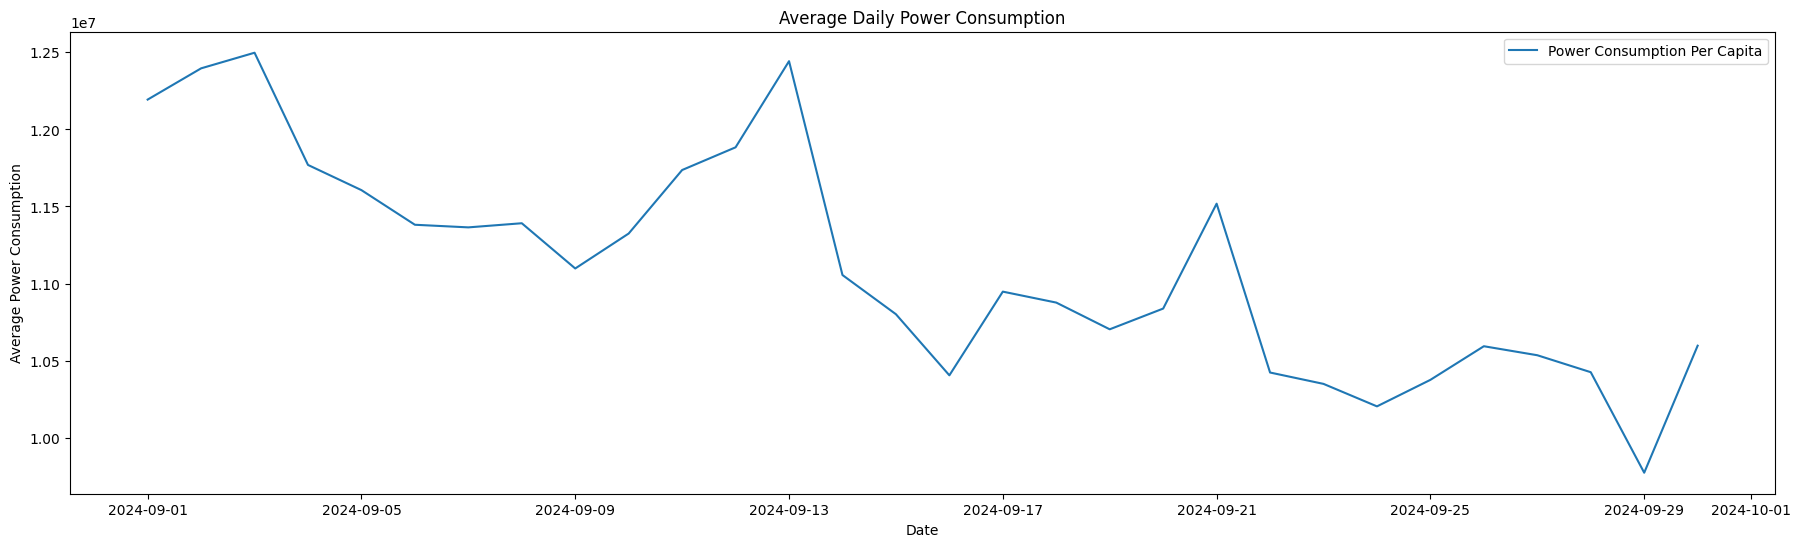

In [22]:
plt.figure(figsize=(22, 6))
sns.lineplot(data=dc_daily_sum)
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Power Consumption Per Capita'])
plt.show()

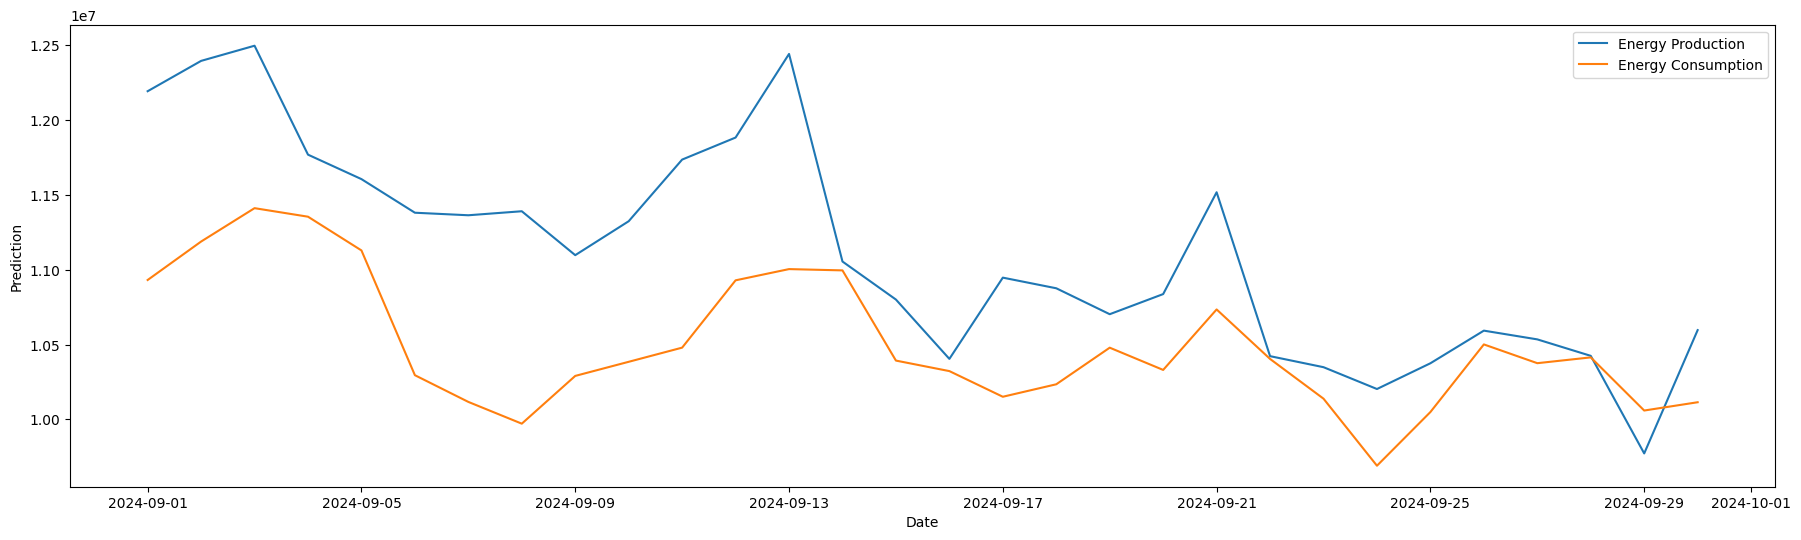

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(22, 6))

# Ensure that both data are plotted correctly by specifying x and y
sns.lineplot(x=dc_daily_sum.index, y=dc_daily_sum['Prediction'], label='Energy Production')
sns.lineplot(x=daily_sum.index, y=daily_sum['Prediction'], label='Energy Consumption')

# Add labels and title
plt.xlabel('Date')

# Show legend and plot
plt.legend()
plt.show()
